# Estudi del Règim Hidrodinàmic mig i extremal de Portocolom (i sucedanis)
### Treball de Fi de Grau
### Universitat de les Illes Balears
### Grau de Física
### Curs 2023-2024
#### Autor: Marc Uguet Vallbona
#### Tutora: Marta I. Marcos Moreno 

## Apèndix A
A continuació definim funcions simples que ens poden resultar de gran utilitat en el desenvolupament del treball. Sovint són creades per a facilitar la lectura del codi i per a casos molt específics.

Difícilment seran depenents d'altres llibreries i/o funcions. Encara així aprofitam per a importar les llibreries que més sovint farem servir.

In [123]:
# imports
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
# from mpl_toolkits.basemap import Basemap
from matplotlib.colors import ListedColormap
import pickle
# import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# globals
path_Data_CoExMed_Balears = r"C:\Users\uvmar\OneDrive\Escriptori\Data_CoExMed_Balears"  #TODO: fer que aquesta variable sigui funcional

In [98]:
def isiterable(obj):
    """
    Comprova si un objecte és iterable
    :param obj: objecte a comprovar
    :return: True si és iterable, False si no ho és
    """
    try:
        iter(obj)
        return True
    except TypeError:
        return False
    

def lat_lon_depth() -> list:  # TODO: funciona però ho he fet de manera ràpida, crec que se toca poder implementar dins sa funció extractor_dades empleant es parametre 'variables'. REVISAR
    """
    Retorna una llista amb les latituds, longituds i profunditats dels punts de la nostra malla espacial.
    :return: list [lat, lon, depth]
    """    
    path = r"D:\tfg\Data_CoExMed_Balears\1950.mat"
    data_raw = sio.loadmat(path, variable_names=['lat', 'lon', 'depth'])
    
    return [data_raw['lat'][0], data_raw['lon'][0], data_raw['depth'][0]]


def llegir_pkl(path: str) -> dict:
    """
    Llegeix arxius en un fitxer .pkl
    :param path: path del fitxer .pkl
    :return: dades del fitxer .pkl en format diccionari
    """
    import pickle
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data

## Apèndix B
Introduïm aqui funcions pròpies de certa complexitat que ens seran d'utilitat més envant.

La funcionalitat, explicació i exemples d'ús de cada funció es troba documentada dins el mateix codi.

In [2]:
def extractor_dades(punts='def', variables='def', anys=range(1950, 2023)) -> dict:
    """
    Llegeix les dades dels punts i variables que li indiquem. El diccionari resultant està ordenat per claus: punt, any, variable.
    Recordem que les dades són horàries i, per tant, cada any conté 8760 valors.
    :param punts: Punt o punts dels quals es volen llegir les dades. 'def' pels 8 punts d'interès, 'tot' per tots els punts. Ha de ser un enter o un objecte iterable d'enters.
    :param variables: Ídem que punts, però per les variables. 'def' per les 5 variables usuals, 'tot' per totes les variables. Ha de ser un string o un objecte iterable de strings.
    :param anys: Anys dels quals es volen llegir les dades.
    :return: dict amb les dades llegides.
    """    
    if punts == 'def':  # punts per defecte
        punts = {'Portocolom': 1366, 'Es Trenc': 1291, 'Port de Sóller': 353, 'Cap Farrutx': 1319,
                 'Men. Nord': 764, 'Men. Sud': 1021, 'Eivissa Est': 912, 'Formentera Sud': 1339}
    elif punts == 'tot':  # tots els punts
        # TODO: fer que també funcioni si es volen llegir tots els punts
        raise NotImplementedError()
    elif not isinstance(punts, (int, list, tuple, dict)):
        # TODO: revisar aquest cas
        raise TypeError('Format no vàlid per a punts. Ha de ser int, list o tuple')

    if variables == 'def':  # variables per defecte
        variables = ('elev_hydro', 'elev_wavedpt', 'Hs_wavedpt', 'Tp_wavedpt', 'Dp_wavedpt')
    elif variables == 'tot':  # totes les variables
        # TODO: fer que també funcioni si es volen llegir totes les variables
        raise NotImplementedError('Encara no s\'ha implementat la lectura de totes les variables')
    elif not isinstance(variables, (str, list, tuple)):
        # TODO: revisar aquest cas
        raise TypeError('Format no vàlid per a variables. Ha de ser str, list o tuple')
    
    # TODO: fer comprovacions sobre els valors que s'introdueixen dins anys
    
    data = {}
    for anyi in tqdm(anys, desc='Llegint anys'):
        path = r"D:\tfg\Data_CoExMed_Balears\{}.mat".format(anyi)
        data_raw = sio.loadmat(path, variable_names=variables)

        df_tot = {}
        for key in variables:
            df_tot[key] = pd.DataFrame(data=data_raw[key])

        df_punts = {}
        for key in df_tot.keys():
            df_punts[key] = df_tot[key].iloc[:, list(punts.values())]

        data[anyi] = df_punts

    # posam amb l'ordre desitjat, reformam i retornam
    data_ref = {}
    for kpunt, vpunt in punts.items():
        data_ref[kpunt] = {}
        for var in variables:
            data_ref[kpunt][var] = {}
            for anyi in anys:
                data_ref[kpunt][var][anyi] = list(data[anyi][var][vpunt])

    return data_ref

# COMPROVACIÓ
# dades_1999 = extractor_dades(punts='def', variables='def', anys=[1999])
# print(dades_1999['Portocolom']['elev_hydro'][1999][:10])


def plot_costa_Basemap(axi, reg=None, lati=None, loni=None, res='h'):  #TODO: BORRAR, ara mateix ja no s'emplea perquè tenim Cartopy. Refer funció empleant cartopy
    """
    Pinta la línia de costa de la regió que li indiquem. Si no li indiquem res, pinta la línia de costa de les Illes Balears.
    :param ax: Eix sobre el qual volem pintar la línia de costa.
    :param reg: Regió de la qual volem pintar la línia de costa. Si no s'indica, es pintarà la línia de costa de les Illes Balears.
    :param lati: Latituds de la regió de la qual volem pintar la línia de costa.
    :param loni: Longituds de la regió de la qual volem pintar la línia de costa.
    :param res: Resolució de la línia de costa. 'c' per crude, 'l' per low, 'i' per intermediate, 'h' per high, 'f' per full.
    :return: None
    """
    
    # comprovam que els arguments siguin correctes
    if reg is not None and (lati is not None or loni is not None):
        raise ValueError('No es poden indicar simultàniament regió i latitud/longitud')
    if reg is None and (lati is None or loni is None):
        raise ValueError('S\'ha d\'indicar regió o latitud/longitud')
    regions_permeses = ('IB', 'MALL', 'MEN', 'EIV', 'FOR', 'MALL_MEN', 'PITI', 'TEST')
    if reg is not None:
        if not isinstance(reg, str):
            raise TypeError('El nom de la regió ha de ser un string. Els valors permesos són: IB, MALL, MEN, EIV, FOR, MALL_MEN, PITI o TEST')
        reg = reg.upper()
        if reg not in regions_permeses:
            raise ValueError('El nom de la regió no és vàlid. Els valors permesos són: IB, MALL, MEN, EIV, FOR, MALL_MEN, PITI o TEST')
        elif reg == 'IB':
            lati = [38.5, 40.5]
            loni = [1., 4.5]
        elif reg == 'MALL':
            lati = [39.2, 40.2]
            loni = [2.5, 4.5]
        # TODO: completar la resta de regions
    if lati is not None and loni is not None:
        if not isiterable(lati) or not isiterable(loni):
            raise TypeError('lat i lon han de ser objectes iterables')
        if len(lati) < 2 or len(loni) < 2:
            raise ValueError('lat i lon han de tenir com a mínim 2 valors')
    
    m = Basemap(projection='mill', llcrnrlat=min(lati), urcrnrlat=max(lati), llcrnrlon=min(loni), urcrnrlon=max(loni), resolution=res, ax=axi)
    m.drawcoastlines()
    
    return m

# COMPROVACIÓ
# import matplotlib.pyplot as plt
# plot_costa('IB')
# plt.show()


def crear_percentils(var_names = None, punts = None, full_time_series = False) -> None:
    """
    Crea un fitxer .pkl amb els percentils de les variables d'interès per a tots els punts.
    :param var_names: Noms de les variables d'interès. Per defecte ('elev_hydro', 'elev_wavedpt', 'Hs_wavedpt', 'Tp_wavedpt', 'Dp_wavedpt').
    :param punts: Punts espacials dels quals es volen calcular els percentils. Per defecte els 8 punts d'interès.
    :param full_time_series: Si es vol calcular la sèrie temporal completa. Si és False (per defecte), es calcularan els percentils per cada any.
    :return: 
    """
    # demanam a l'usuari si vol executar la funció, ja que pot trigar molt
    res = input('Aquesta funció pot tardar molt. Vols continuar? (s/[n])')
    if res not in ('s', 'S'):
        return
    
    if var_names is None:
        var_names = ('elev_hydro', 'elev_wavedpt', 'Hs_wavedpt', 'Tp_wavedpt', 'Dp_wavedpt')
    elif not isiterable(var_names):
        raise TypeError('var_names ha de ser un objecte iterable tot i que sigui d\'un sol element. Ex.: ("elev_hydro",) o ["elev_hydro"]')
    
    if punts is None:
        punts = [353, 764, 912, 1021, 1291, 1319, 1339, 1366]
    elif punts == 'tot':
        punts = list(range(0, np.shape(sio.loadmat(r"D:\tfg\Data_CoExMed_Balears\1950.mat")['lat'])[1]))
    elif not isiterable(punts):
        raise TypeError('punts ha de ser un objecte iterable tot i que sigui d\'un sol element. Ex.: (353,) o [353]')
    
    if full_time_series:
        if len(var_names) > 1:
            raise Exception('Si es vol calcular la sèrie temporal completa, només es pot calcular una variable a la vegada per evitar que el càlcul sigui massa llarg.')
    
    percentils_res = {}
    decimals = None
    df = {}
    var_name = var_names[0]
    if full_time_series:
        # demanam si és necessari arredonir els valors de les variables i si és així, quants decimals
        siround = input('Vols arrodonir els valors de les variables? (s/[n])')
        if siround in ('s', 'S'):
            decimals = int(input('A quants decimals?'))
    for year in tqdm(range(1950, 2023), desc='Càlcul percentils per any'):
        #TODO: fer que l'usuari tengui l'opció de aturar el procés (per cada 10 anys per exemple demanar si es vol continuar)
        #TODO: fer que funcioni si es vol calcular la sèrie temporal completa
        data_raw = sio.loadmat(r"D:\tfg\Data_CoExMed_Balears\{}.mat".format(year), variable_names=var_names)
        # cream diccionari de dataframes
        if not full_time_series:
            df = {}
            for key in var_names:
                df[key] = pd.DataFrame(data=data_raw[key])
            # ens quedam només amb les columnes (punts espacials) d'interès
            df_punts = {}
            for key in df.keys():
                df_punts[key] = df[key].iloc[:, punts]
            # calculam els percentils
            percentils_i = {}
            for key in df_punts.keys():
                percentils_i[key] = df_punts[key].quantile(q=[0.5, 0.95, 0.99], axis=0)
            # guardam dins un dict
            percentils_res[year] = percentils_i
        elif full_time_series and var_name == 'Dp_wavedpt':
            data = data_raw['Dp_wavedpt']
            if decimals:
                data = np.round(data, decimals)
                if decimals == 0:
                    data = data.astype(int)
            if var_name not in df.keys():
                df[var_name] = data
            else:
                df[var_name] = np.concatenate([df[var_name], data], axis=0)

    # guardam sa variable percentils en format .pkl
    res = input('Vols guardar els percentils en un fitxer .pkl? (s/[n])')
    if res in ('s', 'S'):
        nom_arxiu = input('Nom de l\'arxiu ("percentils" per defecte) (sense extensió): ')
        if nom_arxiu == '':
            nom_arxiu = 'percentils'
        with open(r"D:\tfg\pkls\{}.pkl".format(nom_arxiu), 'wb') as f:
            pickle.dump(percentils_res, f)

# COMPROVACIÓ
# crear_percentils()

## 0. Dades i metodologia
Les dades estan ubicades dins una carpeta (*path*) amb arxius .mat separats per anys. Des del 1950.mat el 2022.mat.  

## 1. Primer tractament de les dades.
### Visualització dels punts de malla sobre un mapa de les Illes Balears
Procedirem a la creació de diversos mapes de les Illes Balears amb els punts de malla que hem extret de les dades. La intenció és representar-hi amb diferents colormaps les diferents magnituts que se'n puguin extreure de les dades.

Com a primer contacte amb les dades, hi mostrarem la profunditat dels punts de malla.

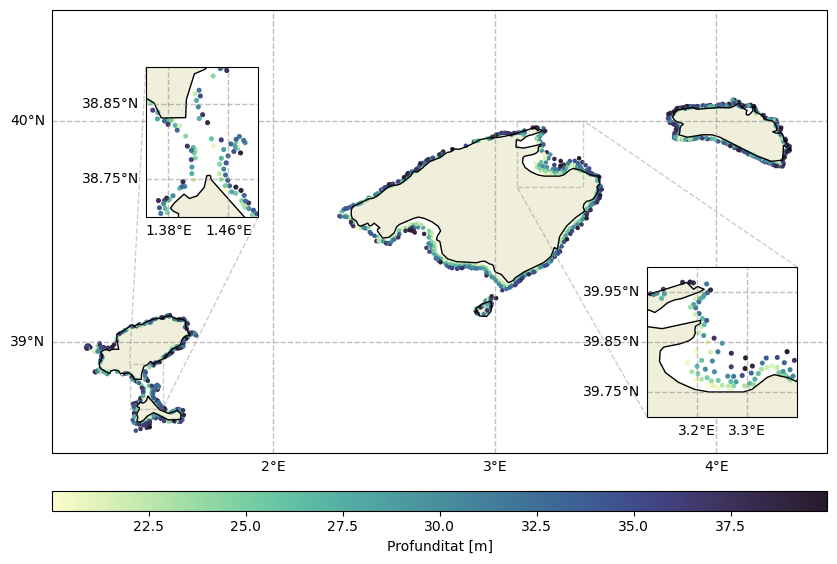

In [114]:
lat, lon, depth = lat_lon_depth()  # extreim les dades

# ara llegirem el colormap que volem
rgb = np.loadtxt(r"D:\tfg\figures\cmaps\cmocean_deep.rgb") / 255  # normalitzam els valors
cmocean_deep = ListedColormap(rgb)

# ara farem el plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

ax.set_extent([1., 4.5, 38.5, 40.5])
ax.add_feature(cfeature.COASTLINE.with_scale('10m'))  # resolucions: 10m, 50m, 110m
ax.add_feature(cfeature.LAND)

sc = ax.scatter(lon, lat, c=depth, cmap=cmocean_deep, s=5)

cbar = plt.colorbar(sc, ax=ax, label='Profunditat [m]', orientation='horizontal', pad=0.05, aspect=40)

# gridlines
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator(range(1, 6, 1))  # adjust as per your extent
gl.ylocator = mticker.FixedLocator(range(38, 41, 1))  # adjust as per your extent

# zoom a platja de Muro
ax_inset = plt.axes([0.72, 0.3, 0.15, 0.15], projection=ccrs.PlateCarree())
ax_inset.set_extent([3.1, 3.4, 39.7, 40])
ax_inset.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax_inset.add_feature(cfeature.LAND)
sc_inset = ax_inset.scatter(lon, lat, c=depth, cmap=cmocean_deep, s=7)
mark_inset(ax, ax_inset, loc1=1, loc2=3, fc="none", ec=".5", alpha=.4, linestyle='--')

# gridlins a l'inset
gl_inset = ax_inset.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl_inset.top_labels = gl_inset.right_labels = False
gl_inset.xformatter = LONGITUDE_FORMATTER
gl_inset.yformatter = LATITUDE_FORMATTER
gl_inset.xlocator = mticker.FixedLocator(np.arange(3.1, 3.6, 0.1))  # adjust as per your extent
gl_inset.ylocator = mticker.FixedLocator(np.arange(39.75, 40, 0.1))  # adjust as per your extent

# zoom al pas entre Eivissa i Formentera
ax_inset2 = plt.axes([0.2, 0.5, 0.15, 0.15], projection=ccrs.PlateCarree())
ax_inset2.set_extent([1.35, 1.5, 38.7, 38.9])
ax_inset2.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax_inset2.add_feature(cfeature.LAND)
sc_inset2 = ax_inset2.scatter(lon, lat, c=depth, cmap=cmocean_deep, s=7)
mark_inset(ax, ax_inset2, loc1=2, loc2=4, fc="none", ec=".5", alpha=.4, linestyle='--')

# gridlins a l'inset2
gl_inset2 = ax_inset2.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl_inset2.top_labels = gl_inset2.right_labels = False
gl_inset2.xformatter = LONGITUDE_FORMATTER
gl_inset2.yformatter = LATITUDE_FORMATTER
gl_inset2.xlocator = mticker.FixedLocator([1.38, 1.46])  # adjust as per your extent
gl_inset2.ylocator = mticker.FixedLocator([38.75, 38.85])  # adjust as per your extent

plt.show()

## 2. Anàlisi. Estudi del comportament de les variables durant tota la sèrie temporal.

### 2.1. Direcció de l'onatge
En primer lloc, volem estudiar la direcció de l'onatge per a veure d'on prové l'onatge a cada punt de malla majoritàriament. Per a fer-ho, calcularem la mitjana de les direccions tenint en compte que són variables angulars i, per tant, hem de fer servir les funcions sinus i cosinus per a calcular-ne la mitjana.

In [115]:
var_name = 'Dp_wavedpt'
data_mean_angle = None
data_mean_radi = None

# demanam si volem executar el càlcul
res = input('Aquest càlcul pot tardar molt. Vols continuar? (s/[n])')
if res not in ('s', 'S'):
    raise SystemExit

# sabem que tenim 1400 punts de malla (0-1399) i 8760 hores per any, com que la sèrie temporal tant sí com no la necessitam sencera, procedirem a fer el càlcul de 200 punts en 200 punts.
pas = 200
for reg in tqdm(range(0, 1400, pas), desc=f'Recorrem punts de malla de {pas} en {pas}'):
    data_sin, data_cos = None, None
    for year in range(1950, 2023):
        data_raw = sio.loadmat(r"C:\Users\uvmar\OneDrive\Escriptori\Data_CoExMed_Balears\{}.mat".format(year), variable_names=(var_name,))
        data = np.round(data_raw[var_name]).astype(int)[:, reg:reg + pas]
        data_radians = np.round(np.deg2rad(data), 4)
        data_radians = pd.DataFrame(data_radians)
        data_sin_temp = data_radians.apply(np.sin)
        data_cos_temp = data_radians.apply(np.cos)
        data_sin = pd.concat([data_sin, data_sin_temp], ignore_index=True) if data_sin is not None else data_sin_temp
        data_cos = pd.concat([data_cos, data_cos_temp], ignore_index=True) if data_cos is not None else data_cos_temp
    data_sin_mean = data_sin.mean()
    data_cos_mean = data_cos.mean()
    data_mean_angle_reg = np.arctan2(data_sin_mean, data_cos_mean)
    data_mean_angle_reg = np.rad2deg(data_mean_angle_reg)
    data_mean_angle = pd.concat([data_mean_angle, data_mean_angle_reg], ignore_index=True) if data_mean_angle is not None else data_mean_angle_reg
    data_mean_radi_reg = np.sqrt(data_sin_mean ** 2 + data_cos_mean ** 2)
    data_mean_radi = pd.concat([data_mean_radi, data_mean_radi_reg], ignore_index=True) if data_mean_radi is not None else data_mean_radi_reg
data_mean_res = {'angle': data_mean_angle, 'radi': data_mean_radi}

# guardam sa variable percentils en format .pkl
res = input('Vols guardar la mitjana de les direccions en un fitxer .pkl? (s/[n])')
if res in ('s', 'S'):
    nom_arxiu = input('Nom de l\'arxiu ("mitjana_Dp_wavedpt_FTS" per defecte) (sense extensió): ')
    if nom_arxiu == '':
        nom_arxiu = 'mitjana_Dp_wavedpt_FTS'
    with open(r"D:\tfg\pkls\{}.pkl".format(nom_arxiu), 'wb') as f:
        pickle.dump(data_mean_res, f)

Recorrem punts de malla de 200 en 200: 100%|██████████| 7/7 [06:06<00:00, 52.32s/it]


Una vegada tenim les dades disponibles i adeqüadament tractadaes i guardades, podem procedir a la seva representació gràfica.
Farem un plot similar a l'anterior, però en aquest cas representarem la mitjana de les direccions de l'onatge.

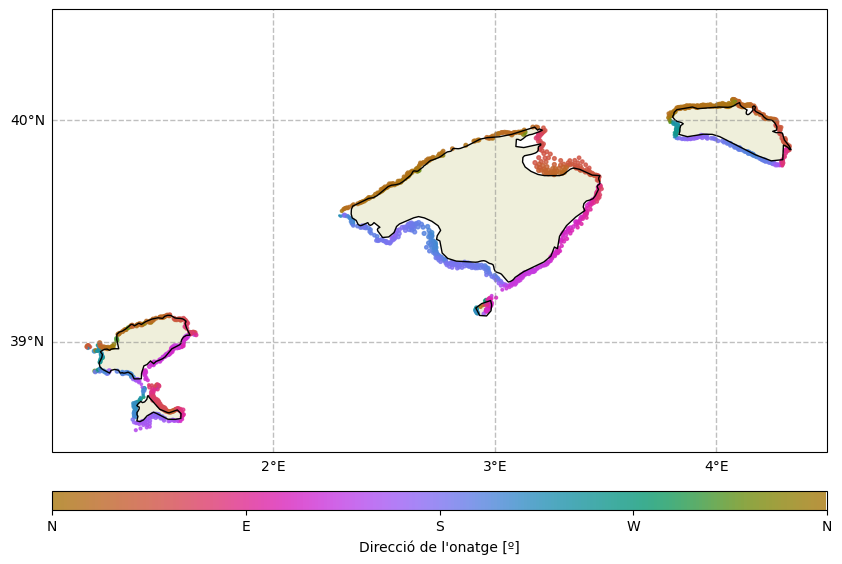

In [121]:
# llegim dades
path = r"D:\tfg\pkls\mitjana_Dp_wavedpt.pkl"
try:
    data_mean_res = llegir_pkl(path)
except FileNotFoundError:
    raise FileNotFoundError('No s\'ha trobat l\'arxiu .pkl amb les dades de la mitjana de les direccions de l\'onatge')

# modificam els angles perquè vagin de 0 a 360
data_mean_res['angle'][np.where(data_mean_res['angle'] < 0)[0]] += 360

# llegim el colormap
rgb = np.loadtxt(r"D:\tfg\figures\cmaps\cmocean_phase.rgb") / 255  # normalitzam els valors
cmocean_phase = ListedColormap(rgb)

# voldrem que la mida dels punts sigui proporcional al radi de les direccions
radi = data_mean_res['radi']

# plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([1., 4.5, 38.5, 40.5])
ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax.add_feature(cfeature.LAND)

sc = ax.scatter(lon, lat, c=data_mean_res['angle'], cmap=cmocean_phase, s=10*radi, alpha=.8)

cbar = plt.colorbar(sc, ax=ax, label='Direcció de l\'onatge [º]', orientation='horizontal', pad=0.05, aspect=40)
cbar.set_ticks([0, 90, 180, 270, 360])
cbar.set_ticklabels(['N', 'E', 'S', 'W', 'N'])

# gridlines
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator(range(1, 6, 1))  # adjust as per your extent
gl.ylocator = mticker.FixedLocator(range(38, 41, 1))  # adjust as per your extent

plt.show()

### 2.2. Altura de l'onatge
En segon lloc, volem estudiar l'altura de l'onatge per a veure quins són els punts de malla més afectats per l'onatge. Per a fer-ho, calcularem la mitjana de les alçades de l'onatge. També es calcularan els percentils 95 i 99 per a cada punt de malla.

In [141]:
var_name = 'Hs_wavedpt'
data_calc = None

# demanam si volem executar el càlcul
res = input('Aquest càlcul pot tardar molt. Vols continuar? (s/[n])')
if res not in ('s', 'S'):
    raise SystemExit

pas = 200
for reg in tqdm(range(0, 1400, pas), desc=f'Recorrem punts de malla de {pas} en {pas}'):
    data_reg = None
    for year in range(1950, 2023):
        data_raw = sio.loadmat(r"C:\Users\uvmar\OneDrive\Escriptori\Data_CoExMed_Balears\{}.mat".format(year), variable_names=(var_name,))
        data_temp = pd.DataFrame(data_raw[var_name][:, reg:reg + pas])
        data_reg = pd.concat([data_reg, data_temp], ignore_index=True) if data_reg is not None else data_temp
    data_calc_reg = data_reg.quantile(q=[0.5, 0.95, 0.99], axis=0)
    data_calc = pd.concat([data_calc, data_calc_reg], axis=1, ignore_index=True) if data_calc is not None else data_calc_reg
    
# guardam sa variable percentils en format .pkl
res = input('Vols guardar els percentils en un fitxer .pkl? (s/[n])')
if res in ('s', 'S'):
    nom_arxiu = input('Nom de l\'arxiu ("percentils_Hs_wavedpt_FTS" per defecte) (sense extensió): ')
    if nom_arxiu == '':
        nom_arxiu = 'percentils_Hs_wavedpt_FTS'
    with open(r"D:\tfg\pkls\{}.pkl".format(nom_arxiu), 'wb') as f:
        pickle.dump(data_calc, f)

Recorrem punts de malla de 200 en 200: 100%|██████████| 7/7 [02:41<00:00, 23.13s/it]


A continuació, emprant les dades recent calculades, procedim a la creació de un mapa idèntic a l'anterior però representant-hi la mediana de l'altura de l'onatge.

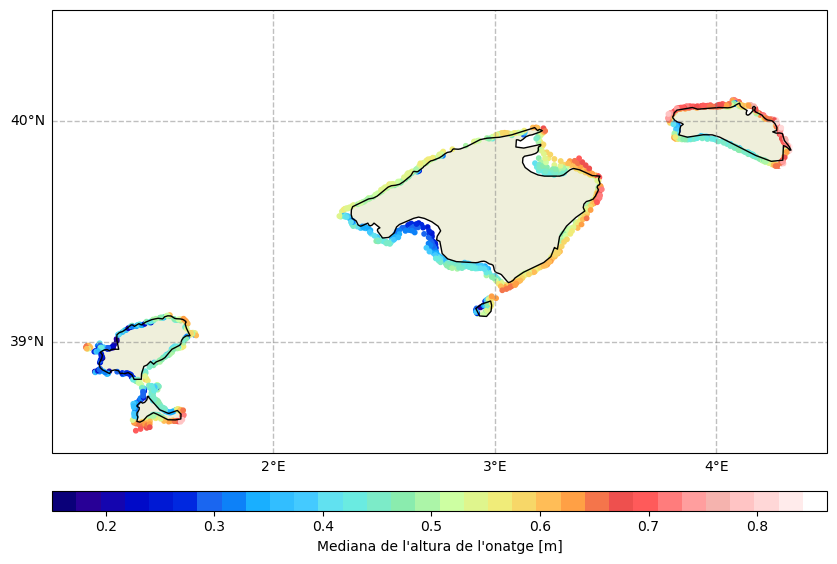

In [142]:
# llegim dades
path = r"D:\tfg\pkls\percentils_Hs_wavedpt_FTS.pkl"
try:
    percentils_Hs_wavedpt_FTS = llegir_pkl(path)
except FileNotFoundError:
    raise FileNotFoundError('No s\'ha trobat l\'arxiu .pkl amb les dades dels percentils de l\'altura de l\'onatge')

# llegim el colormap
rgb = np.loadtxt(r"D:\tfg\figures\cmaps\GMT_haxby.rgb")
gmt_haxby = ListedColormap(rgb)

# plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([1., 4.5, 38.5, 40.5])
ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax.add_feature(cfeature.LAND)

sc = ax.scatter(lon, lat, c=percentils_Hs_wavedpt_FTS.loc[0.5], cmap=gmt_haxby, s=10)

cbar = plt.colorbar(sc, ax=ax, label='Mediana de l\'altura de l\'onatge [m]', orientation='horizontal', pad=0.05, aspect=40)

# gridlines
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator(range(1, 6, 1))  # adjust as per your extent
gl.ylocator = mticker.FixedLocator(range(38, 41, 1))  # adjust as per your extent

plt.show()

Ara repetirem el procés però creant 3 mapes un damunt l'altre dins una mateixa figura. Cada mapa representarà un percentil diferent (0.5, 0.95 i 0.99).

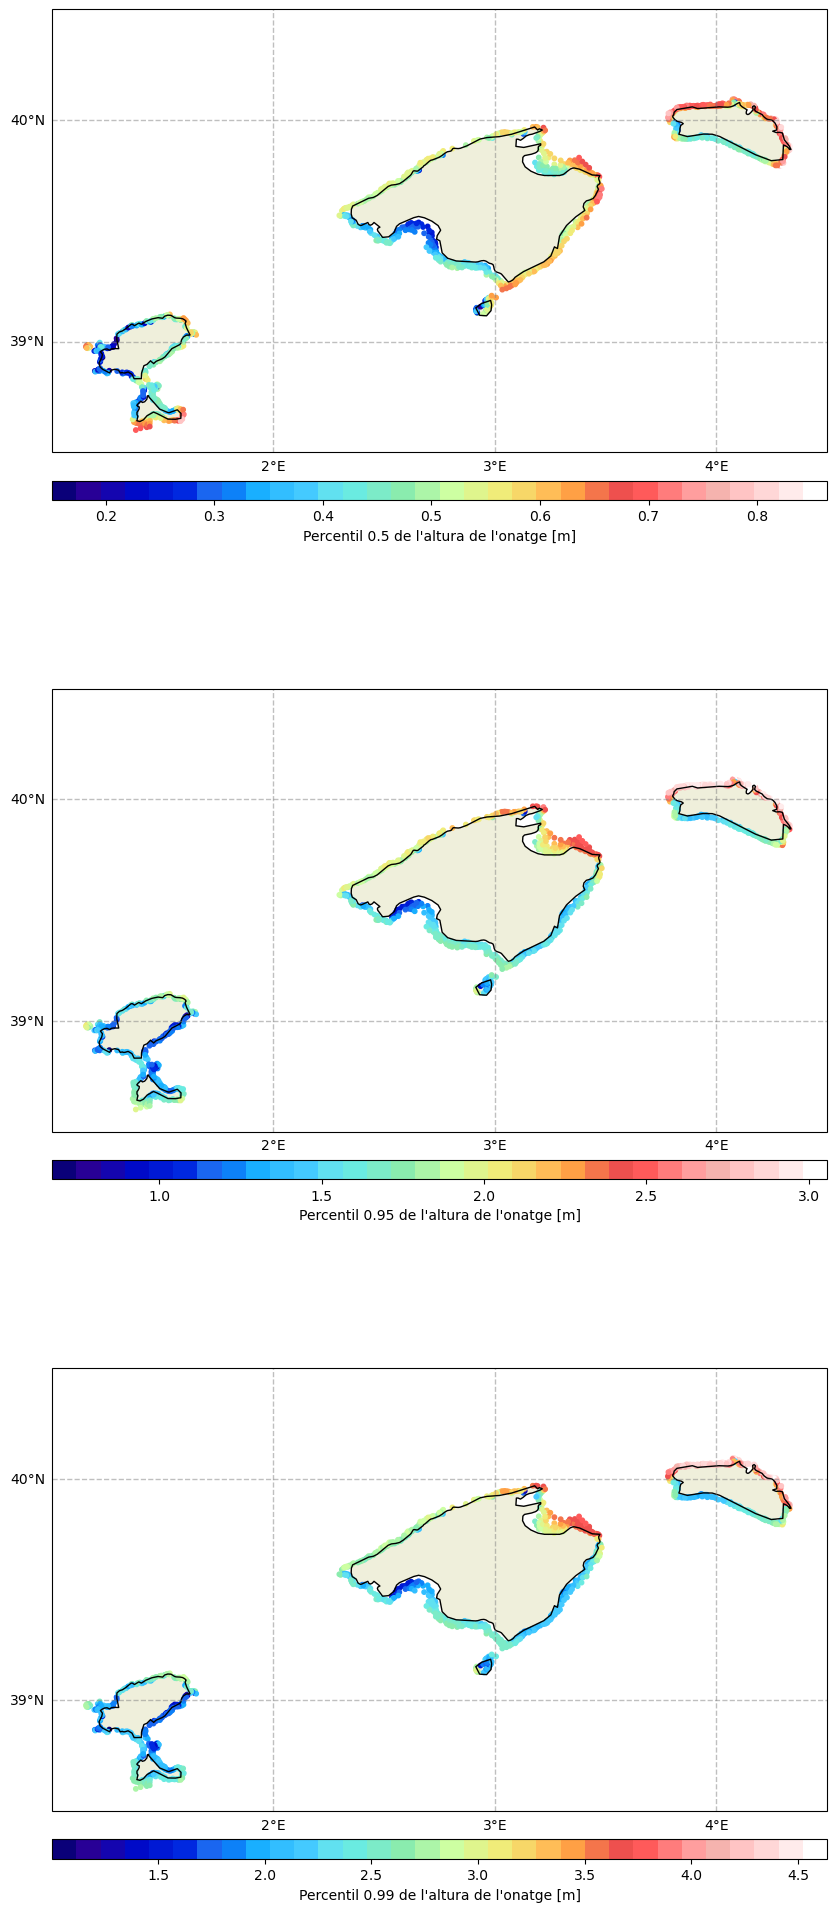

In [138]:
# llegim dades
path = r"D:\tfg\pkls\percentils_Hs_wavedpt_FTS.pkl"
try:
    percentils_Hs_wavedpt_FTS = llegir_pkl(path)
except FileNotFoundError:
    raise FileNotFoundError('No s\'ha trobat l\'arxiu .pkl amb les dades dels percentils de l\'altura de l\'onatge')

# llegim el colormap
rgb = np.loadtxt(r"D:\tfg\figures\cmaps\GMT_haxby.rgb")
gmt_haxby = ListedColormap(rgb)

# plots, cream una figura amb 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 25), subplot_kw={'projection': ccrs.PlateCarree()})

for i, ax in enumerate(axs):
    ax.set_extent([1., 4.5, 38.5, 40.5])
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
    ax.add_feature(cfeature.LAND)

    sc = ax.scatter(lon, lat, c=percentils_Hs_wavedpt_FTS.loc[percentils_Hs_wavedpt_FTS.index[i]], cmap=gmt_haxby, s=10, alpha=1)

    cbar = plt.colorbar(sc, ax=ax, label=f'Percentil {percentils_Hs_wavedpt_FTS.index[i]} de l\'altura de l\'onatge [m]', orientation='horizontal', pad=0.05, aspect=40)

    # gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator(range(1, 6, 1))  # adjust as per your extent
    gl.ylocator = mticker.FixedLocator(range(38, 41, 1))  # adjust as per your extent
    
plt.show()

### 2.3. Període de l'onatge
Per al període de l'onatge, el que se'ns demana és calcular la mitja del període per aquells punts temporals que superen el percentil 95 en altura d'onatge. Això ho farem per a cada punt de malla.

Els percentils de Hs ja els tenim calculats, ara però hem de tornar a llegir els arxius per guardar els indexs que satisfan la nostra condició.

In [ ]:
# llegim dades
path = r"D:\tfg\pkls\percentils_Hs_wavedpt_FTS.pkl"
try:
    percentils_Hs_wavedpt_FTS = llegir_pkl(path)
except FileNotFoundError:
    raise FileNotFoundError('No s\'ha trobat l\'arxiu .pkl amb les dades dels percentils de l\'altura de l\'onatge')

# demanam si volem executar el càlcul
res = input('Aquest càlcul pot tardar molt. Vols continuar? (s/[n])')
if res not in ('s', 'S'):
    raise SystemExit

pas = 200
data_calc = None
var_names = ('Tp_wavedpt', 'Hs_wavedpt')
for reg in tqdm(range(0, 1400, pas), desc=f'Recorrem punts de malla de {pas} en {pas}'):
    data_reg = None
    for year in range(1950, 2023):
        data_raw = sio.loadmat(r"C:\Users\uvmar\OneDrive\Escriptori\Data_CoExMed_Balears\{}.mat".format(year), variable_names=var_names)
        data_temp = {var_name: pd.DataFrame(data_raw[var_name][:, reg:reg + pas]) for var_name in var_names}
        if data_reg is None:
            data_reg = {var_name: data_temp[var_name].loc[data_temp['Hs_wavedpt'] > percentils_Hs_wavedpt_FTS.loc[0.95, reg]] for var_name in var_names}
        else:
            data_reg = {var_name: pd.concat([data_reg[var_name], data_temp[var_name].loc[data_temp['Hs_wavedpt'] > percentils_Hs_wavedpt_FTS.loc[0.95, reg]]], ignore_index=True) for var_name in var_names}
    data_calc_reg = data_reg.quantile(q=[0.5, 0.95, 0.99], axis=0)
    data_calc = pd.concat([data_calc, data_calc_reg], axis=1) if data_calc is not None else data_calc_reg
    
# guardam sa variable percentils en format .pkl
res = input('Vols guardar els percentils en un fitxer .pkl? (s/[n])')
if res in ('s', 'S'):
    nom_arxiu = input('Nom de l\'arxiu ("percentils_Hs_wavedpt_FTS" per defecte) (sense extensió): ')
    if nom_arxiu == '':
        nom_arxiu = 'percentils_Hs_wavedpt_FTS'
    with open(r"D:\tfg\pkls\{}.pkl".format(nom_arxiu), 'wb') as f:
        pickle.dump(data_calc, f)

## 3. Anàlisi de les dades. Càlcul i representació de percentils d'interès.
A n'aquest apartat farem ús de les funcions crea_percentils i llegir_pkl per a calcular i llegir els percentils de les variables d'interès.

In [122]:
path = r"D:\tfg\pkls\percentils.pkl"
try:
    percentils = llegir_pkl(path)
except FileNotFoundError:
    crear_percentils()
    percentils = llegir_pkl(path)

# el format de percentils és: any -> variable -> punt -> percentil
# ex.: p95_75_elevhydro_soller = percentils[1975]['elev_hydro'][353][0.95]
# print(percentils)

Una vegada tenim les dades per mà, podem començar amb les representacions gràfiques.